# Human Related Data getter
the following piece of codes is related to human acctivies data any indices can be helpful

## Human population
UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020)


In [ ]:
import netCDF4 as nc
import pandas as pd
import numpy as np

# Open the netCDF file for population density
file_path = "G:/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc"
dataset = nc.Dataset(file_path, 'r')

# Extract variables
lon = dataset['longitude'][:]  # Shape: (8640,)
lat = dataset['latitude'][:]  # Shape: (4320,)
# Assuming 'raster' dimension represents time or scenarios, adjust as needed
time_slices = dataset.dimensions['raster'].size  # Assuming this represents years or time slices
population_density = dataset['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'][:]

# Morocco's bounding box coordinates
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

# Filter lon and lat based on Morocco's bounding box
morocco_lon_indexes = np.where((lon >= morocco_min_lon) & (lon <= morocco_max_lon))[0]
morocco_lat_indexes = np.where((lat >= morocco_min_lat) & (lat <= morocco_max_lat))[0]

# Initialize DataFrame to store data
morocco_population_data = pd.DataFrame()

# Iterate over each time slice
for t in range(time_slices):
    data_list = []
    for i in morocco_lat_indexes:
        for j in morocco_lon_indexes:
            latitude = lat[i]
            longitude = lon[j]
            population_density_value = population_density[t, i, j]
            # Append latitude, longitude, and population density to the list
            # Assuming 't' can be mapped to a year or time slice description
            data_list.append([latitude, longitude, t, population_density_value])

    # Convert list to DataFrame
    temp_df = pd.DataFrame(data_list, columns=['Latitude', 'Longitude', 'Raster', 'PopulationDensity'])
    morocco_population_data = pd.concat([morocco_population_data, temp_df], axis=0)

# Show the DataFrame structure
print(morocco_population_data.head())

# Close the dataset
dataset.close()


In [ ]:
morocco_population_data2=morocco_population_data[morocco_population_data.PopulationDensity!='--']
morocco_population_data2.to_parquet('Data/HumanActivities/morocco_population_data.parquet')

In [ ]:
morocco_population_data2.to_parquet('Data/HumanActivities/morocco_population_data.parquet')

In [1]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming world is already loaded as a GeoDataFrame
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

def filter_points_within_morocco(df):
    """
    Filter rows based on whether their point locations fall within Morocco.

    Args:
    df (pd.DataFrame): A DataFrame containing 'Latitude' and 'Longitude' columns.

    Returns:
    gpd.GeoDataFrame: A GeoDataFrame containing only the rows where points are within Morocco.
    """
    # Ensure the input DataFrame has 'Latitude' and 'Longitude' columns
    if not {'Latitude', 'Longitude'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'Latitude' and 'Longitude' columns")

    # Convert the DataFrame to a GeoDataFrame, setting the geometry from Latitude and Longitude
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    # Filter the world GeoDataFrame to include only Morocco
    morocco = world[world['ADMIN'] == 'Morocco'].geometry.iloc[0]

    # Filter rows where geometry is within Morocco
    gdf_within_morocco = gdf[gdf.geometry.within(morocco)]

    return gdf_within_morocco

# Example usage:
# Assuming you have a DataFrame `df` with 'Latitude' and 'Longitude'
# df_within_morocco = filter_points_within_morocco(df)
# print(df_within_morocco)


In [ ]:
gdf_within_morocco

In [ ]:
sample_morocco_population_data=morocco_population_data2.sample(1000)

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt



# Convert DataFrame to GeoDataFrame
gdf_morocco = gpd.GeoDataFrame(
    sample_morocco_population_data, 
    geometry=gpd.points_from_xy(sample_morocco_population_data.Longitude, sample_morocco_population_data.Latitude)
)

# Morocco's bounding box coordinates
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

# Read the shapefile for country boundaries
countries_gdf = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Filter for Morocco using the bounding box (this assumes Morocco is within the bounding box)
morocco_boundary = countries_gdf.cx[morocco_min_lon:morocco_max_lon, morocco_min_lat:morocco_max_lat]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
morocco_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_morocco.plot(ax=ax, column='PopulationDensity', legend=True, markersize=10, cmap='viridis')

plt.title('Population Density in Morocco')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


NameError: name 'sample_morocco_population_data' is not defined

## Data from tiff 2020 30arc-seconde

In [1]:
import rasterio
import pandas as pd
import numpy as np

def tiff_to_dataframe(tiff_path):
    # Open the TIFF file
    with rasterio.open(tiff_path) as src:
        # Read the first band (assuming population density is in the first band)
        band1 = src.read(1)
        
        # Initialize a list to hold data
        data_list = []
        
        # Get the affine transform to calculate geographic coordinates
        transform = src.transform
        
        # Iterate over each pixel in the raster
        for row in range(band1.shape[0]):
            for col in range(band1.shape[1]):
                # Skip no data values (adjust this value as per your raster's metadata)
                if band1[row, col] != src.nodata:
                    # Calculate the geographic coordinates for the current pixel
                    x, y = rasterio.transform.xy(transform, row, col, offset='center')
                    # Append the coordinates and population density value to the list
                    data_list.append({'Latitude': y, 'Longitude': x, 'PopulationDensity': band1[row, col]})
        
        # Convert the list to a DataFrame
        df = pd.DataFrame(data_list)
        
        return df

# Specify the path to your TIFF file
tiff_path = "G:/Tiffgpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec_tif/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_30_sec.tif"

# Convert the TIFF to a DataFrame
df = tiff_to_dataframe(tiff_path)

# Show the first few rows of the DataFrame
print(df.head())


    Latitude  Longitude  PopulationDensity
0  83.629167 -32.687500                0.0
1  83.629167 -32.679167                0.0
2  83.629167 -32.670833                0.0
3  83.629167 -32.662500                0.0
4  83.629167 -32.654167                0.0


In [5]:
# df.to_parquet('Data/HumanActivities/dataframe_gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_.parquet')
population_density_morocco=pd.read_parquet('Data/HumanActivities/dataframe_gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_.parquet')

In [6]:
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

population_density_morocco = population_density_morocco[(population_density_morocco.Latitude >= morocco_min_lat) & (population_density_morocco.Latitude <= morocco_max_lat) & (population_density_morocco.Longitude >= morocco_min_lon) & (population_density_morocco.Longitude <= morocco_max_lon)]
population_density_morocco = filter_points_within_morocco(population_density_morocco)

In [10]:
population_density_moroccobcp=population_density_morocco.copy()

In [24]:
population_density_moroccobcp.to_parquet('Data/FinalDataSet/population_density_morocco_2020_corrected.parquet')

In [35]:
# get top 10000 population density data
# sample_morocco_population_data=population_density_morocco.sort_values(by='PopulationDensity',ascending=False).head(10000).copy()
sample_morocco_population_data=population_density_morocco.sample(100000).copy()

# Convert 'PopulationDensity' to numeric
sample_morocco_population_data['PopulationDensity'] = sample_morocco_population_data['PopulationDensity'].fillna(0)
sample_morocco_population_data['PopulationDensity'] = pd.to_numeric(sample_morocco_population_data['PopulationDensity'], errors='coerce')

# Round 'PopulationDensity' to two decimal places
# sample_morocco_population_data['PopulationDensity'] = sample_morocco_population_data['PopulationDensity'].round(3)
#normalize
# sample_morocco_population_data['PopulationDensity'] = ((sample_morocco_population_data['PopulationDensity'] - sample_morocco_population_data['PopulationDensity'].min()) / (sample_morocco_population_data['PopulationDensity'].max() - sample_morocco_population_data['PopulationDensity'].min())) * (100 - 0) + 0
sample_morocco_population_data=sample_morocco_population_data[(sample_morocco_population_data.PopulationDensity>10)&(sample_morocco_population_data.PopulationDensity<2000)]


In [33]:
sample_morocco_population_data

,Latitude,Longitude,PopulationDensity,geometry
125496515,33.829167,-5.329167,161.789429,POINT (-5.32917 33.82917)
133414287,30.254167,-9.337500,264.371490,POINT (-9.33750 30.25417)
133046915,30.412500,-9.070833,167.775864,POINT (-9.07083 30.41250)
127418101,32.920833,-7.212500,134.973694,POINT (-7.21250 32.92083)
130918750,31.329167,-7.929167,132.553131,POINT (-7.92917 31.32917)
...,...,...,...,...
129710417,31.870833,-7.320833,244.001068,POINT (-7.32083 31.87083)
125232863,33.954167,-6.770833,519.639099,POINT (-6.77083 33.95417)
127938670,32.679167,-8.487500,121.732620,POINT (-8.48750 32.67917)
122777624,35.087500,-5.979167,190.275757,POINT (-5.97917 35.08750)


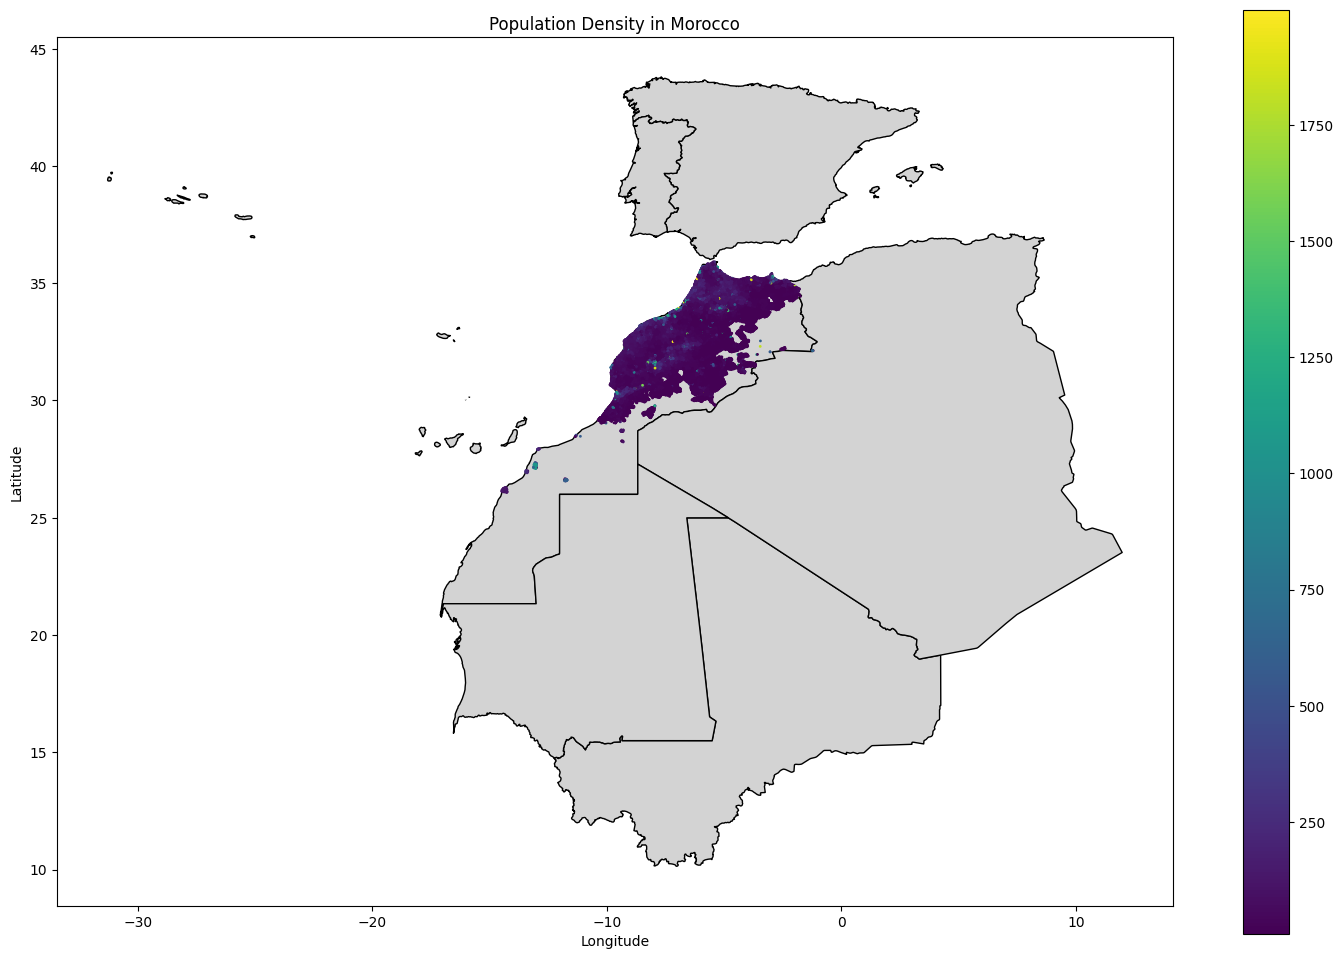

In [36]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt



# Convert DataFrame to GeoDataFrame
gdf_morocco = gpd.GeoDataFrame(
    sample_morocco_population_data, 
    geometry=gpd.points_from_xy(sample_morocco_population_data.Longitude, sample_morocco_population_data.Latitude)
)

# Morocco's bounding box coordinates
morocco_min_lon, morocco_min_lat, morocco_max_lon, morocco_max_lat = -17.10464433, 20.76691315, -1.03199947, 35.92651915

# Read the shapefile for country boundaries
countries_gdf = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Filter for Morocco using the bounding box (this assumes Morocco is within the bounding box)
morocco_boundary = countries_gdf.cx[morocco_min_lon:morocco_max_lon, morocco_min_lat:morocco_max_lat]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
morocco_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_morocco.plot(ax=ax, column='PopulationDensity', legend=True, markersize=1, cmap='viridis')

plt.title('Population Density in Morocco')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [9]:
import ee
from IPython.display import Image

# Initialize the Earth Engine module.
ee.Initialize()

# Load an image.
dataset = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density').first()
raster = dataset.select('population_density')

# Define visualization parameters in an object literal.
raster_vis = {
  'max': 1000.0,
  'palette': ['ffffe7', 'FFc869', 'ffac1d', 'e17735', 'f2552c', '9f0c21'],
  'min': 200.0
}

# Center the map and display the image.
ee.mapclient.centerMap(79.1, 19.81, 3)
ee.mapclient.addToMap(raster, raster_vis, 'population_density')


ModuleNotFoundError: No module named '_curses'